<a href="https://colab.research.google.com/github/rubuntu/Taller_Introduccion_a_Ciencia_de_Datos_IA_e_Ingenieria_de_Datos/blob/main/sesion_15_fine_tuning_bert_analisis_de_sentimientos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sesión 15: Fine-tuning de BERT para Análisis de Sentimiento


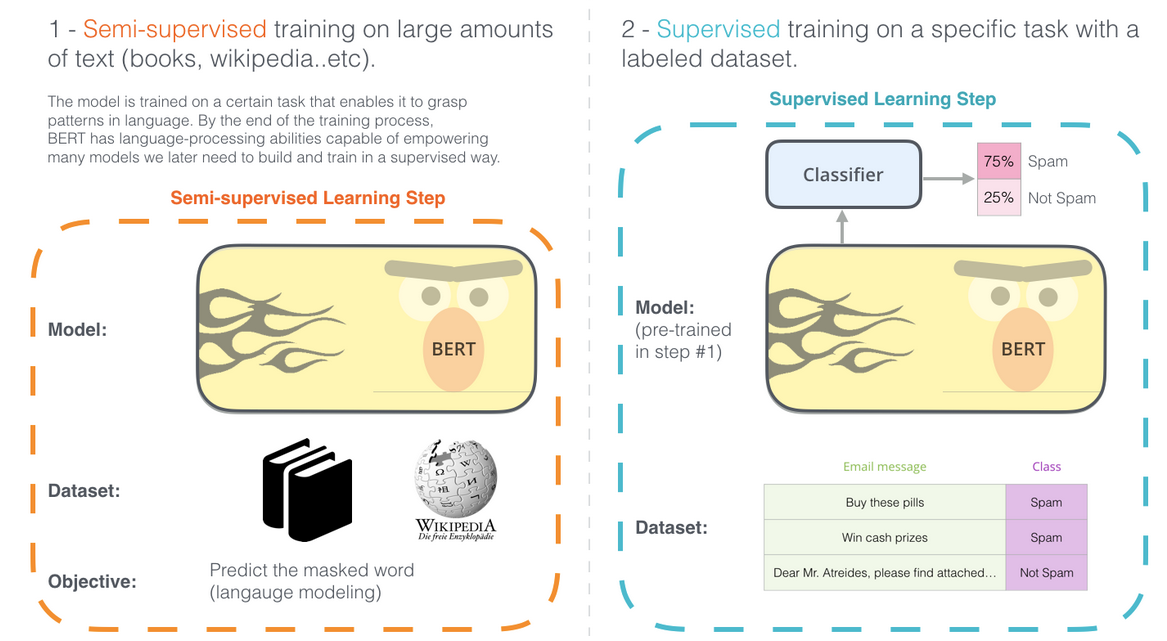

## Objetivos

- Aprender a entrenar (fine-tune) BERT en reseñas de clientes.

- Evaluar métricas de clasificación binaria.

- Experimentar con distintos tamaños y parámetros de dataset.


---

**Checklist:**

1. Cargar dataset IMDB (subconjunto: 2000 train, 1000 test).

2. Tokenizar y preparar dataset para Transformers.

3. Definir modelo `AutoModelForSequenceClassification` con 2 clases.

4. Configurar entrenamiento con `Trainer`.

5. Entrenar por 2 épocas y monitorear métricas.

6. Probar con reseñas nuevas (escritas por los alumnos).

7. Experimento comparativo:
      - Reducir `max_length` de 128 → 64.    
      - Cambiar tamaño de dataset (500 vs 2000 ejemplos).    
      - Discutir impacto en accuracy/F1.

**Referencia:** [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/)


---

## 1. Tokenizar dataset



In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Carga dataset completo como DatasetDict
dataset = load_dataset("imdb")

# Reduce tamaño si quieres solo un subset
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(2000))
dataset["test"]  = dataset["test"].shuffle(seed=42).select(range(1000))

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

# Aplica tokenización a cada split
encoded_ds = dataset.map(tokenize_fn, batched=True)

# Renombra y prepara formato para torch
encoded_ds = encoded_ds.rename_column("label","labels")
encoded_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])


---
**Explicación**

```python
from datasets import load_dataset
from transformers import AutoTokenizer
```

👉 Importa las funciones necesarias:

* `load_dataset` de 🤗 Datasets para cargar datasets.
* `AutoTokenizer` de 🤗 Transformers para convertir texto en tokens numéricos.

---

```python
# Carga dataset completo como DatasetDict
dataset = load_dataset("imdb")
```

👉 Descarga y carga el dataset **IMDB** (reseñas de películas en inglés, clasificadas como positivas o negativas).

* Se obtiene un objeto `DatasetDict` con dos divisiones: `train` (entrenamiento) y `test` (evaluación).

---

```python
# Reduce tamaño si quieres solo un subset
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(2000))
dataset["test"]  = dataset["test"].shuffle(seed=42).select(range(1000))
```

👉 Reduce el tamaño del dataset para entrenar más rápido:

* `shuffle(seed=42)` mezcla aleatoriamente los ejemplos, pero con semilla fija para reproducibilidad.
* `select(range(2000))` toma solo los **primeros 2000 ejemplos** del conjunto de entrenamiento.
* `select(range(1000))` toma los **primeros 1000 ejemplos** del conjunto de test.

---

```python
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
```

👉 Carga el *tokenizer* asociado a BERT base uncased (sin mayúsculas).
Este convierte texto a IDs de tokens que BERT entiende.

---

```python
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
```

👉 Define una función de tokenización:

* `batch["text"]` → toma la columna de texto del dataset.
* `truncation=True` → corta textos más largos que `max_length`.
* `padding="max_length"` → rellena los textos más cortos hasta `max_length`.
* `max_length=128` → cada ejemplo se convierte en una secuencia de **128 tokens** exactos.

---

```python
# Aplica tokenización a cada split
encoded_ds = dataset.map(tokenize_fn, batched=True)
```

👉 Aplica la tokenización a **todos los ejemplos** del dataset (train y test).

* `batched=True` procesa lotes completos en lugar de un ejemplo a la vez (más rápido).
* El resultado incluye nuevas columnas: `input_ids` y `attention_mask`.

---

```python
# Renombra y prepara formato para torch
encoded_ds = encoded_ds.rename_column("label","labels")
encoded_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])
```

👉 Ajusta el dataset para que funcione con PyTorch y el `Trainer`:

* Cambia el nombre de la columna `label` a `labels` (es lo que espera `Trainer`).
* `set_format("torch", ...)` convierte esas columnas en tensores de PyTorch listos para usar en entrenamiento (`input_ids`, `attention_mask`, `labels`).

---

✅ Este bloque **carga IMDB → reduce tamaño → tokeniza → prepara dataset para PyTorch**.
Ya con `encoded_ds`, se puede pasar `encoded_ds["train"]` y `encoded_ds["test"]` al `Trainer` de Hugging Face para entrenar un modelo.



---
## 2. Definir modelo y entrenamiento



In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Modelo
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Función de métricas usando sklearn
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")  # weighted para clases desbalanceadas
    }

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    report_to="tensorboard",
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["test"],
    compute_metrics=compute_metrics
)

trainer.train()



---
**Explicación**
```python
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
```

👉 Importa las librerías necesarias:

* `AutoModelForSequenceClassification`: modelo de BERT ya adaptado a clasificación de texto.
* `TrainingArguments`: donde defines hiperparámetros y configuración de entrenamiento.
* `Trainer`: clase de Hugging Face que automatiza el loop de entrenamiento y evaluación.
* `numpy`: para operaciones de arrays.
* `sklearn.metrics`: funciones para calcular métricas (`accuracy`, `f1`).

---

```python
# Modelo
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
```

👉 Carga el modelo base **BERT uncased** y le añade una capa final de clasificación (`num_labels=2` → positivo/negativo).

* Los pesos de BERT se cargan preentrenados.
* La capa final (`classifier.weight`, `classifier.bias`) se inicializa desde cero y se entrenará en la tarea IMDB.

---

```python
# Función de métricas usando sklearn
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")  # weighted para clases desbalanceadas
    }
```

👉 Define cómo calcular métricas durante la evaluación:

* `eval_pred` trae los `logits` (predicciones sin normalizar) y las etiquetas verdaderas (`labels`).
* `np.argmax(logits, axis=-1)` → convierte logits en clases predichas (0 o 1).
* Devuelve diccionario con **accuracy** y **f1**.
* `average="weighted"` en `f1` promedia considerando el desbalance entre clases.

---

```python
# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    report_to="tensorboard",
)
```

👉 Configuración de entrenamiento:

* `output_dir="./results"`: carpeta donde se guardarán checkpoints y logs.
* `eval_strategy="epoch"`: se evalúa al final de cada época.
* `num_train_epochs=2`: número de pasadas completas por el dataset de entrenamiento.
* `per_device_train_batch_size=16`: tamaño de batch en entrenamiento.
* `per_device_eval_batch_size=16`: tamaño de batch en evaluación.
* `report_to="tensorboard"`: envía métricas a TensorBoard (en lugar de `wandb`).

---

```python
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["test"],
    compute_metrics=compute_metrics
)
```

👉 Crea un objeto `Trainer` que centraliza todo:

* El modelo que vas a entrenar.
* Los argumentos (`training_args`).
* Los datos de entrenamiento y evaluación (`encoded_ds`).
* La función de métricas personalizada.

---

```python
trainer.train()
```

👉 Lanza el proceso de entrenamiento:

* Entrena BERT (fine-tuning) en IMDB durante 2 épocas.
* Evalúa después de cada época.
* Guarda logs en `./results` y métricas en TensorBoard.

---

✅ Este bloque toma el dataset tokenizado, define un modelo BERT para clasificación binaria, establece métricas, configura hiperparámetros y entrena el modelo con Hugging Face `Trainer`.



---
## 3. Probar modelo con nuevas reseñas



In [ ]:
import torch

test_texts = ["This was the best movie ever!", "Worst experience of my life."]
tokens = tokenizer(test_texts, return_tensors="pt", padding=True, truncation=True)

# Detecta el device del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
tokens = {k: v.to(device) for k, v in tokens.items()}

# Predicciones
with torch.no_grad():
    preds = model(**tokens).logits.argmax(dim=1)

print(preds)



---
## 4. Experimentos comparativos


* Cambiar `max_length` de 128 → 64.

* Reducir dataset de 2000 → 500 ejemplos.

* Observar impacto en métricas.


In [ ]:
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=64   # 👈 antes era 128
    )


dataset["train"] = dataset["train"].shuffle(seed=42).select(range(500))   # antes 2000
dataset["test"]  = dataset["test"].shuffle(seed=42).select(range(500))    # antes 2000

encoded_ds = dataset.map(tokenize_fn, batched=True)
encoded_ds = encoded_ds.rename_column("label","labels")
encoded_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["test"],
    compute_metrics=compute_metrics
)

trainer.train()



---

## Preguntas de discusión

### 1. ¿Qué diferencia ves entre entrenar desde cero y hacer *fine-tuning*?

* **Entrenar desde cero (from scratch):**

  * El modelo parte con pesos aleatorios.
  * Necesita un dataset **muy grande** (millones de ejemplos) para aprender desde lo básico.
  * Consume más tiempo y recursos de cómputo.
  * Riesgo de que el modelo no aprenda nada útil si los datos son pocos.

* **Fine-tuning (ajuste fino):**

  * El modelo parte de un **preentrenamiento** (ej. BERT ya ha visto enormes cantidades de texto).
  * Solo necesitas ajustar la capa final y un poco las capas intermedias con tu dataset específico (ej. reseñas de películas).
  * Requiere menos datos y entrena mucho más rápido.
  * Normalmente obtiene mejores resultados en dominios específicos con pocos recursos.

👉 En la práctica, casi siempre se prefiere el *fine-tuning*.

---

### 2. ¿Cómo afecta reducir la longitud máxima o el tamaño del dataset?

* **Reducir `max_length` (ej. de 128 → 64):**

  * Se pierde contexto en reseñas largas, porque los tokens más allá de 64 se cortan.
  * Esto puede llevar a menor exactitud y `f1`, sobre todo si la parte importante de la reseña está hacia el final.
  * A cambio, el entrenamiento es más rápido y usa menos memoria GPU.

* **Reducir el dataset (ej. de 2000 → 500 ejemplos):**

  * Hay menos datos para que el modelo aprenda → mayor riesgo de sobreajuste.
  * Las métricas en entrenamiento pueden ser altas, pero en evaluación/test caen porque el modelo no generaliza.
  * En tareas de NLP, la cantidad y diversidad de datos suele ser más importante que entrenar muchas épocas.

---

### 3. ¿Cómo adaptarías este pipeline a reseñas en español?

* **Elegir un modelo preentrenado en español o multilingüe:**

  * Ejemplos: `dccuchile/bert-base-spanish-wwm-uncased`, `bertin-project/bertin-roberta-base-spanish`, o `xlm-roberta-base`.
* **Cambiar el tokenizer:**

  ```python
  tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
  ```
* **Dataset en español:**

  * Usar reseñas de cine en español (ej. corpus de reseñas de Amazon en español o crear tu dataset).
* **El pipeline sería igual:**

  * Tokenizar → mapear a tensores → definir métricas → entrenar con `Trainer`.

👉 La clave es que el modelo base entienda el idioma (no tendría sentido usar `bert-base-uncased` para reseñas en español).

---

